In [105]:
import numpy as np
from keras.layers import Input, Dense, Conv1D, AvgPool1D, MaxPool1D, Flatten, UpSampling1D, Reshape, BatchNormalization, LSTM, Lambda, concatenate, TimeDistributed
from keras import optimizers
from keras.models import Model
from keras import regularizers
from keras.utils import to_categorical, print_summary
from keras.callbacks import CSVLogger
from sklearn.cluster import KMeans
from datasources import LoadMachineMonitoringData
from matplotlib import pyplot as plt
from scipy import ndimage as nd

n_clusters = 5
n_features = 5

In [70]:
def RandomWindowSampler(input, output):
    for idx in range(output.shape[0]):
        sample_len = np.random.randint(low=80, high=120)
        sample_start = np.random.randint(low=0, high=input.shape[1] - sample_len)
        sample_end = sample_start + sample_len
        sample_idx = np.random.randint(low=0, high=input.shape[0])
        sample = input[sample_idx, sample_start:sample_end, :]
        output[idx, :, :] = nd.zoom(sample, (n_samples / sample_len, 1))

In [149]:
print('Loading data...')
train_60s, test_60s, validate_60s, meta = LoadMachineMonitoringData()
n_samples = 100

n_train_samples = 20 * train_60s.shape[0] * (train_60s.shape[1] // n_samples)
n_test_samples = 20 * test_60s.shape[0] * (test_60s.shape[1] // n_samples)
n_validate_samples = 20 * validate_60s.shape[0] * (validate_60s.shape[1] // n_samples)

n_input_features = train_60s.shape[2]

print('Allocating memory for 10s sumbsamples used in training, testing and validation...')
train = np.zeros((n_train_samples, n_samples, n_input_features), dtype=np.float32)
test = np.zeros((n_test_samples, n_samples, n_input_features), dtype=np.float32)
validate = np.zeros((n_validate_samples, n_samples, n_input_features), dtype=np.float32)

print('Randomly sampling training data...')
RandomWindowSampler(train_60s, train)
print('Randomly sampling testing data...')
RandomWindowSampler(test_60s, test)
print('Randomly sampling validation data...')
RandomWindowSampler(validate_60s, validate)

print('No. of samples: train: {:}, test: {:}, validate: {}'.format(train.shape[0], test.shape[0], validate.shape[0]))

print('Scaling data to the range [0;1] for each feature...')
x_min = train.min(axis=(0, 1))
x_max = train.max(axis=(0, 1))
for channel_idx in range(x_min.size):
    train[:, :, channel_idx] = (train[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    test[:, :, channel_idx] = (test[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    validate[:, :, channel_idx] = (validate[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    
used_ch_idx = 4
train = train[:, :, [used_ch_idx]]
test = test[:, :, [used_ch_idx]]
validate = validate[:, :, [used_ch_idx]]

Loading data...
Allocating memory for 10s sumbsamples used in training, testing and validation...
Randomly sampling training data...
Randomly sampling testing data...
Randomly sampling validation data...
No. of samples: train: 1486800, test: 496800, validate: 662400
Scaling data to the range [0;1] for each feature...


In [226]:
kernel_l1 = 1e-7
kernel_l2 = 1e-7
bias_l1 = 0#1e-4
bias_l2 = 0#1e-4
activation_l1 = 0
activation_l2 = 0

In [235]:
from keras import backend as K
def mean_squared_residual(y_true, y_pred, eps=1e-6):
    msr = K.mean(K.square((y_pred - y_true) / (y_true + eps)), axis=-2)
    delta_true = y_true[:, :-1] - y_true[:, 1:]
    delta_pred = y_pred[:, :-1] - y_pred[:, 1:]
    grad = K.mean(K.square((delta_pred - delta_true) / (delta_true + eps)), axis=-2)
    return msr + 1e-5 * grad

def mse_with_grad(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true), axis=-2)
    delta_true = y_true[:, :-2, :] - y_true[:, 2:, :]
    delta_pred = y_pred[:, :-2, :] - y_pred[:, 2:, :]
    grad_1 = K.mean(K.square(delta_pred - delta_true), axis=-2)
    delta_true = y_true[:, :-2, :] - 2 * y_true[:, 1:-1, :] + y_true[:, 2:, :]
    delta_pred = y_pred[:, :-2, :] - 2 * y_pred[:, 1:-1, :] + y_pred[:, 2:, :]
    grad_2 = K.mean(K.square(delta_pred - delta_true), axis=-2)
    return mse + 2 * grad_1 + 1 * grad_2

In [236]:
EncoderInputs = Input(shape=(train.shape[1], train.shape[2],))

RegularizerParams = {
    'kernel_regularizer': regularizers.l1_l2(kernel_l1, kernel_l2),
    'bias_regularizer': regularizers.l1_l2(bias_l1, bias_l2)
}

HiddenLayerParams = {
    'activation': 'tanh',
    **RegularizerParams,
    'activity_regularizer': regularizers.l1_l2(activation_l1, activation_l2)
}

OutputLayerParams = {
    'activation': 'relu',
    **RegularizerParams
}

EncoderOutput = EncoderInputs
EncoderOutput = Flatten()(EncoderOutput)
EncoderOutput = Dense(n_features, **HiddenLayerParams, )(EncoderOutput)

EncoderModel = Model(inputs=EncoderInputs, outputs=EncoderOutput)
EncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(EncoderModel)

DenseLayerNeurons = EncoderModel.layers[-2].output_shape[1]
OutputLayerShape = (EncoderModel.layers[-3].output_shape[1], EncoderModel.layers[-3].output_shape[2])
AutoEncoderOutput = Dense(DenseLayerNeurons, **OutputLayerParams)(EncoderOutput)
AutoEncoderOutput = Reshape(OutputLayerShape)(AutoEncoderOutput)
# AutoEncoderOutput = Dense(17, **OutputLayerParams)(EncoderOutput)

Optimizer = 'adam'#optimizers.Adam(lr=1e-3, clipnorm=0.1, decay=0.01)

AutoEncoderModel = Model(inputs=EncoderInputs, outputs=AutoEncoderOutput)
AutoEncoderModel.compile(
    optimizer=Optimizer,
    loss=mse_with_grad,#'mse',#mean_squared_residual,
    metrics=['mse', mse_with_grad]
)
print_summary(AutoEncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 100, 1)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 5)                 505       
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 100, 1)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_53 (De

In [237]:
ColOffset = (train.shape[1] - AutoEncoderModel.layers[-1].output_shape[1]) // 2
if ColOffset > 0:
    train_y = train[:, ColOffset:-ColOffset, :]
    test_y = test[:, ColOffset:-ColOffset, :]
    validate_y = validate[:, ColOffset:-ColOffset, :]
else:
    train_y = train
    test_y = test
    validate_y = validate
print(train_y.shape)
print(test_y.shape)
print(validate_y.shape)

(1486800, 100, 1)
(496800, 100, 1)
(662400, 100, 1)


In [238]:
log_file_name = 'example1.5_l1={:}_l2={:}_dense-act={:}_output-act={:}_features={:}_log.csv'.format(kernel_l1, kernel_l2, HiddenLayerParams['activation'], OutputLayerParams['activation'], n_features)
csv_logger = CSVLogger(log_file_name, append=False, separator=',')

In [239]:
AutoEncoderModel.fit(train, train_y, validation_data=(test, test_y), batch_size=1*256, epochs=10, callbacks=[csv_logger], shuffle=True)

Train on 1486800 samples, validate on 496800 samples
Epoch 1/10
1486800/1486800 [==============================] - 50s 34us/step - loss: 0.2231 - mean_squared_error: 0.1446 - mse_with_grad: 0.2231 - val_loss: 0.0984 - val_mean_squared_error: 0.0583 - val_mse_with_grad: 0.0984
Epoch 2/10
1486800/1486800 [==============================] - 47s 32us/step - loss: 0.0741 - mean_squared_error: 0.0408 - mse_with_grad: 0.0741 - val_loss: 1.2632e-04 - val_mean_squared_error: 5.9100e-05 - val_mse_with_grad: 1.0216e-04
Epoch 3/10
1486800/1486800 [==============================] - 47s 32us/step - loss: 4.4509e-05 - mean_squared_error: 1.4419e-05 - mse_with_grad: 2.1369e-05 - val_loss: 3.1867e-05 - val_mean_squared_error: 8.2423e-06 - val_mse_with_grad: 9.4212e-06
Epoch 4/10
1486800/1486800 [==============================] - 47s 32us/step - loss: 3.2006e-05 - mean_squared_error: 8.7822e-06 - mse_with_grad: 9.8539e-06 - val_loss: 2.7920e-05 - val_mean_squared_error: 5.2517e-06 - val_mse_with_grad: 6.

In [232]:
pred_validation_y = AutoEncoderModel.predict(validate)
print('Validation MSE: {:}'.format(np.mean((validate_y - pred_validation_y) ** 2)))

Validation MSE: 6.668354672001442e-06


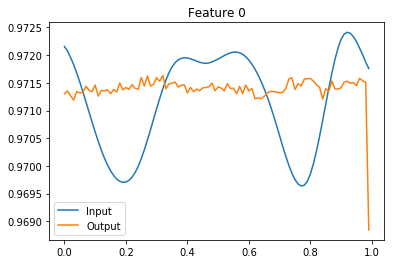

Encoder feature vector: [[-0.7839698  -0.6265154  -0.570281    0.57855684 -0.76324356]]


In [234]:
rnd_sample_idx = np.random.randint(low=0, high=validate_y.shape[0])
time_range = np.arange(0, n_samples) * 0.01
for feature_idx in range(validate_y.shape[2]):
    plt.figure()
    plt.plot(time_range, validate_y[rnd_sample_idx, :, feature_idx], label='Input')
    plt.plot(time_range, pred_validation_y[rnd_sample_idx, :, feature_idx], label='Output')
    plt.legend()
    plt.title('Feature {:}'.format(feature_idx))
    plt.show()
    feature_vec = EncoderModel.predict(validate[[rnd_sample_idx], :, :])
    print('Encoder feature vector: {}'.format(feature_vec))